# EDA (Exploratory Data Analysis)

## Trainings- und Testdaten laden

In [1]:
import pandas as pd
import numpy as np
import sklearn
train = pd.read_csv("./train.csv", sep = ";")
test = pd.read_csv("./test.csv", sep = ";")
train

,transactionId,basket,customerType,totalAmount,returnLabel
0,9534310106,"[4, 3, 4]",new,252.0,1
1,7202594767,"[4, 2, 0, 2, 5]",existing,70.0,0
2,2737331698,[5],existing,84.0,0
3,4868011733,"[1, 4, 2, 4]",existing,116.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",existing,378.0,0
...,...,...,...,...,...
22395,5461363334,"[4, 5, 4]",new,147.0,0
22396,9013779310,"[3, 4, 4, 4, 0]",NaN,NaN,1
22397,1590423615,"[0, 4, 3]",new,249.0,1
22398,1800993941,"[0, 5, 1, 2, 5, 5, 4, 4]",existing,80.0,0


## Histogramme zu den Features `customerType` und `totalAmount`

<AxesSubplot:>

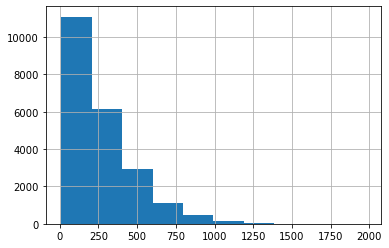

In [2]:
train['totalAmount'].hist()

<AxesSubplot:>

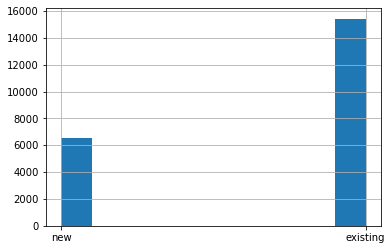

In [3]:
import matplotlib.pyplot as plot
train['customerType'].hist()

## Verteilung von `returnLabel`

<AxesSubplot:>

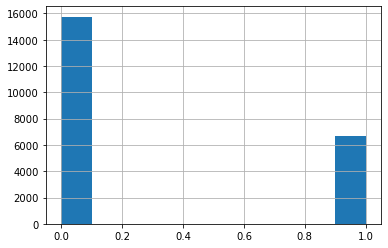

In [4]:
train['returnLabel'].hist()

### In Abhängigkeit zu allen Ausprägungen von `customerType`

<AxesSubplot:>

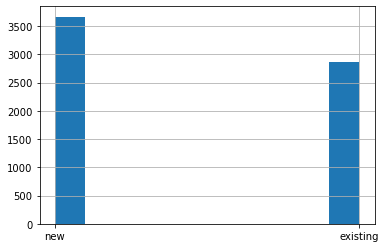

In [5]:
train[(train['returnLabel'] == 1)]['customerType'].hist()

<AxesSubplot:>

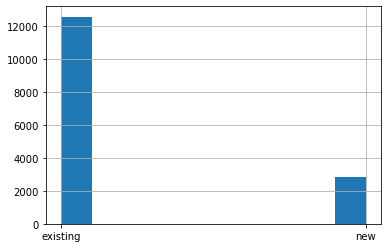

In [6]:
train[(train['returnLabel'] == 0)]['customerType'].hist()

## Boxplot für `totalAmount` in Abhängigkeit von `returnLabel`

<AxesSubplot:title={'center':'totalAmount'}, xlabel='returnLabel'>

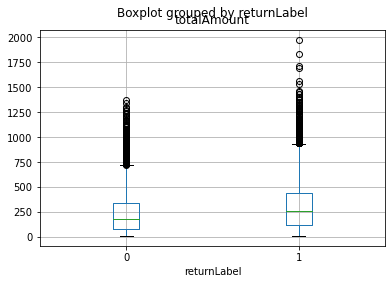

In [7]:
train.boxplot("totalAmount", by="returnLabel")

## Displot für `totalAmount` in Abhängigkeit von `returnLabel`

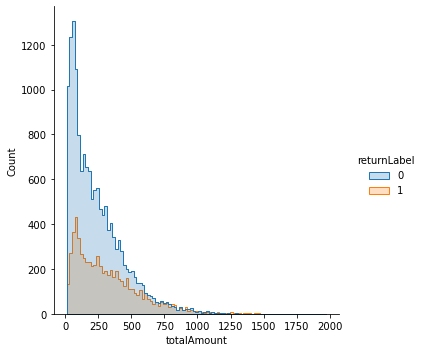

In [8]:
import seaborn
seaborn.displot(train, x="totalAmount", hue="returnLabel", element="step")

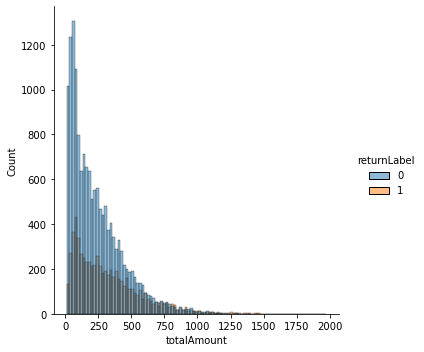

In [9]:
seaborn.displot(train, x="totalAmount", hue="returnLabel", element="bars")

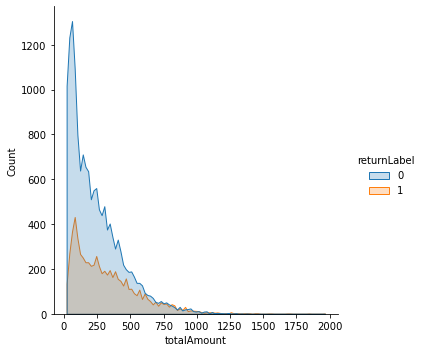

In [10]:
seaborn.displot(train, x="totalAmount", hue="returnLabel", element="poly")

# Auffüllen fehlender Werte in den Trainingsdaten

In [11]:
train.isnull().sum()

transactionId      0
basket             0
customerType     442
totalAmount      477
returnLabel        0
dtype: int64

In [12]:
train['customerType'].fillna(method='ffill', inplace=True)
train['totalAmount'] = train['totalAmount'].fillna(train['totalAmount'].mean())
train.isnull().sum()

transactionId    0
basket           0
customerType     0
totalAmount      0
returnLabel      0
dtype: int64

# One Hot Encoding

In [13]:
def oneHot(dataframe):
    oneHot_FeatureOne = pd.get_dummies(dataframe['customerType'])
    dataframe = dataframe.drop(columns=['customerType'])
    dataframe = pd.concat([dataframe, oneHot_FeatureOne], axis=1)
    return dataframe

In [14]:
def createFeatures(dataframe):
    dataframe = oneHot(dataframe)
    basketFeatures = [[], [], [], [], [], [], []]
    basketFeatureNames = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'totalItems']
    for basketRow in dataframe['basket']:
        totalItems = 0
        basket = [0, 0, 0, 0, 0, 0]
        for item in eval(basketRow):
            basket[item] += 1;
            totalItems += 1;
        basketFeatures[6].append(totalItems)
        for category in range(len(basket)):
            basketFeatures[category].append(basket[category])
    dataframe = dataframe.drop(columns = ['basket'])
    for col in range(len(basketFeatureNames)):
        dataframe[basketFeatureNames[col]] = basketFeatures[col]
    return dataframe

xTrain = createFeatures(train.drop(columns = 'returnLabel'))
yTrain = train['returnLabel']
xTrain.head()

,transactionId,totalAmount,existing,new,c0,c1,c2,c3,c4,c5,totalItems
0,9534310106,252.0,0,1,0,0,0,1,2,0,3
1,7202594767,70.0,1,0,1,0,2,0,1,1,5
2,2737331698,84.0,1,0,0,0,0,0,0,1,1
3,4868011733,116.0,1,0,0,1,1,0,2,0,4
4,7622406570,378.0,1,0,1,0,3,2,0,1,7


# Features skalieren

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(xTrain)
xTrain_scaled = scaler.transform(xTrain)

# Training

## Logistische Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logisticRegParam = [{'C':[0.1, 1, 4, 5, 6, 10, 30, 100], 'penalty': ["l1", "l2"]}]
logisticRegr = LogisticRegression(random_state = 0)
logisticRegrGrid = GridSearchCV(estimator = logisticRegr, param_grid = logisticRegParam, n_jobs = -1)
logisticRegrGrid.fit(xTrain_scaled, yTrain)

C:\Users\jfrit\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.87763393        nan 0.87790179        nan 0.87776786
        nan 0.87776786        nan 0.87776786        nan 0.8778125
        nan 0.8778125         nan 0.8778125 ]
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(random_state=0), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 4, 5, 6, 10, 30, 100],
                          'penalty': ['l1', 'l2']}])

In [17]:
print("Best C: ", logisticRegrGrid.best_estimator_.C)
print("Best penalty: ", logisticRegrGrid.best_estimator_.penalty)

Best C:  1
Best penalty:  l2


## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

randomForestParam = [{'n_estimators': [60, 80, 100, 120, 140], 'max_depth': [2, 4, 6]}]
randomForestClassifier = RandomForestClassifier(random_state=0)
randomForestGrid = GridSearchCV(estimator = randomForestClassifier, param_grid = randomForestParam, n_jobs = -1)
randomForestGrid.fit(xTrain_scaled, yTrain)

GridSearchCV(estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid=[{'max_depth': [2, 4, 6],
                          'n_estimators': [60, 80, 100, 120, 140]}])

In [19]:
print("Best n_estimators: ", randomForestGrid.best_estimator_.n_estimators)
print("Best max_depth: ", randomForestGrid.best_estimator_.max_depth)

Best n_estimators:  120
Best max_depth:  6


## Gradient Boosting

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gradientBoostingParam = [{'n_estimators': [60, 80, 100, 120, 140], 'max_depth': [2, 4, 6]}]
gradientBoostingClassifier = GradientBoostingClassifier(random_state = 0)
gradientBoostingGrid = GridSearchCV(estimator = gradientBoostingClassifier, param_grid = gradientBoostingParam, n_jobs = -1)
gradientBoostingGrid.fit(xTrain_scaled, yTrain)

GridSearchCV(estimator=GradientBoostingClassifier(random_state=0), n_jobs=-1,
             param_grid=[{'max_depth': [2, 4, 6],
                          'n_estimators': [60, 80, 100, 120, 140]}])

In [21]:
print("Best n_estimators: ", gradientBoostingGrid.best_estimator_.n_estimators)
print("Best max_depth: ", gradientBoostingGrid.best_estimator_.max_depth)

Best n_estimators:  140
Best max_depth:  2


# Testen

In [22]:
test = pd.read_csv("./test.csv", sep = ";")
test

,transactionId,basket,customerType,totalAmount,returnLabel
0,4132523932,"[4, 3, 4, 3, 2, 3]",existing,366.0,1
1,8998574539,"[3, 4, 4, 3, 5]",existing,85.0,0
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",existing,275.0,0
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",existing,528.0,0
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",existing,287.0,0
...,...,...,...,...,...
9595,7995301628,"[1, 3]",existing,66.0,0
9596,7387398375,"[1, 4, 3, 3]",existing,40.0,0
9597,2777556607,[4],existing,126.0,1
9598,7205276301,"[4, 5, 4, 1, 0, 2, 0]",existing,70.0,0


In [23]:
xTest = createFeatures(test.drop(columns = 'returnLabel')).dropna()
yTest = test['returnLabel']
yTest = yTest[xTest.index]
xTest

,transactionId,totalAmount,existing,new,c0,c1,c2,c3,c4,c5,totalItems
0,4132523932,366.0,1,0,0,0,1,3,2,0,6
1,8998574539,85.0,1,0,0,0,0,2,2,1,5
2,9346688547,275.0,1,0,1,4,2,2,2,0,11
3,4533897707,528.0,1,0,1,3,2,1,0,1,8
4,3334800500,287.0,1,0,0,1,2,1,1,2,7
...,...,...,...,...,...,...,...,...,...,...,...
9595,7995301628,66.0,1,0,0,1,0,1,0,0,2
9596,7387398375,40.0,1,0,0,1,0,2,1,0,4
9597,2777556607,126.0,1,0,0,0,0,0,1,0,1
9598,7205276301,70.0,1,0,2,1,1,0,2,1,7


## Datenskalierung

In [24]:
xTest_scaled = scaler.transform(xTest)

## Modelle mit den besten Hyperparametern

In [25]:
logRes = LogisticRegression(random_state = 0, C = logisticRegrGrid.best_estimator_.C, penalty=logisticRegrGrid.best_estimator_.penalty)
logRes.fit(xTrain_scaled, yTrain)
logResPredict = logRes.predict(xTest_scaled)

ranForClass = RandomForestClassifier(random_state = 0, n_estimators = randomForestGrid.best_estimator_.n_estimators, max_depth = randomForestGrid.best_estimator_.max_depth)
ranForClass.fit(xTrain_scaled, yTrain)
ranForClassPredict = ranForClass.predict(xTest_scaled)

gradBoostClass = GradientBoostingClassifier(random_state = 0, n_estimators = gradientBoostingGrid.best_estimator_.n_estimators, max_depth = gradientBoostingGrid.best_estimator_.max_depth)
gradBoostClass.fit(xTrain_scaled, yTrain)
gradBoostClassPredict = gradBoostClass.predict(xTest_scaled)

# Accuracy, Precision, Recall

## Logistische Regression

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("Accuracy: ", accuracy_score(yTest, logResPredict))
print("Precision: ", precision_score(yTest, logResPredict))
print("Recall: ", recall_score(yTest, logResPredict))

Accuracy:  0.8719363395225465
Precision:  0.8143806174286831
Recall:  0.7400568181818182


## Random Forest Classifier

In [27]:
print("Accuracy: ", accuracy_score(yTest, ranForClassPredict))
print("Precision: ", precision_score(yTest, ranForClassPredict))
print("Recall: ", recall_score(yTest, ranForClassPredict))

Accuracy:  0.8615384615384616
Precision:  0.8023209283713485
Recall:  0.7120028409090909


## Gradient Boosting Classifier

In [28]:
print("Accuracy: ", accuracy_score(yTest, gradBoostClassPredict))
print("Precision: ", precision_score(yTest, gradBoostClassPredict))
print("Recall: ", recall_score(yTest, gradBoostClassPredict))

Accuracy:  0.8723607427055703
Precision:  0.8035378246142266
Recall:  0.7581676136363636


# Trainingsdaten Accuarcy

## Logistische Regression

In [29]:
print("Accuracy test data: ", accuracy_score(yTest, logResPredict))
logResPredict = logRes.predict(xTrain_scaled)
print("Accuracy train data: ", accuracy_score(yTrain, logResPredict))

Accuracy test data:  0.8719363395225465
Accuracy train data:  0.878125


## Random Forest Classifier

In [30]:
print("Accuracy test data: ", accuracy_score(yTest, ranForClassPredict))
ranForClassPredict = ranForClass.predict(xTrain_scaled)
print("Accuracy train data: ", accuracy_score(yTrain, ranForClassPredict))

Accuracy test data:  0.8615384615384616
Accuracy train data:  0.8710714285714286


## Gradient Boosting Classifier

In [31]:
print("Accuracy test data: ", accuracy_score(yTest, gradBoostClassPredict))
gradBoostClassPredict = gradBoostClass.predict(xTrain_scaled)
print("Accuracy train data: ", accuracy_score(yTrain, gradBoostClassPredict))

Accuracy test data:  0.8723607427055703
Accuracy train data:  0.8809375


# Falsch klassifizierte Datenpunkte

In [32]:
def getIncorrectPoints(yValues, predictions):
    incorrectPoints = set()
    for index, (yVal, predictVal) in enumerate(zip(yValues, predictions)):
        if yVal != predictVal:
            incorrectPoints.add(index)
    return incorrectPoints

## Logistische Regression

In [33]:
logResPredict = logRes.predict(xTest_scaled)
logResIncorrectPoints = getIncorrectPoints(yTest, logResPredict)

## Random Forest Classifier

In [34]:
ranForClassPredict = ranForClass.predict(xTest_scaled)
ranForClassIncorrectPoints = getIncorrectPoints(yTest, ranForClassPredict)

## Gradient Boosting Classifier

In [35]:
gradBoostClassPredict = gradBoostClass.predict(xTest_scaled)
gradBoostClassIncorrectPoints = getIncorrectPoints(yTest, gradBoostClassPredict)

In [39]:
gradBoostClassPredict

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

## Falsche Datenpunkte in allen Modellen

In [37]:
len((gradBoostClassIncorrectPoints.intersection(ranForClassIncorrectPoints)).intersection(logResIncorrectPoints))

927